In [3]:
import sys
from pathlib import Path
import torch
import kagglehub
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

c:\Users\shaund\projects\mmirs-standard-bank\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Add project root to path to easily import needed modules
project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [3]:
# Download dataset
print("Downloading dataset...")
dataset_path = kagglehub.dataset_download(
    "alessandrasala79/ai-vs-human-generated-dataset")
test_data_path = Path(dataset_path) / "test_data_v2"
image_paths = list(test_data_path.glob("*.jpg"))[:500] 
print(f"Loaded {len(image_paths)} images")

Download already complete (10475389582 bytes).
Extracting files...
Loaded 500 images


In [5]:
# Print some basic dataset statistics
image_paths = list(Path(r"C:\Users\shaund\.cache\kagglehub\datasets\alessandrasala79\ai-vs-human-generated-dataset\versions\4\test_data_v2").glob("*.jpg"))[:500]
print(f"Total images loaded: {len(image_paths)}")
print("\nFirst few image paths:")
for path in image_paths[:3]:
    print(f"- {path}")
print("\nImage formats:")
formats = set(Image.open(path).format for path in image_paths[:10])
print(f"- {', '.join(formats)}")

Total images loaded: 500

First few image paths:
- C:\Users\shaund\.cache\kagglehub\datasets\alessandrasala79\ai-vs-human-generated-dataset\versions\4\test_data_v2\0016e1d72d404fe68074cc87cb30aa37.jpg
- C:\Users\shaund\.cache\kagglehub\datasets\alessandrasala79\ai-vs-human-generated-dataset\versions\4\test_data_v2\002cbbdc87f0484db60ed0c261c53e7b.jpg
- C:\Users\shaund\.cache\kagglehub\datasets\alessandrasala79\ai-vs-human-generated-dataset\versions\4\test_data_v2\0030624722ae447b98cd36e9c734fce4.jpg

Image formats:
- PNG, JPEG


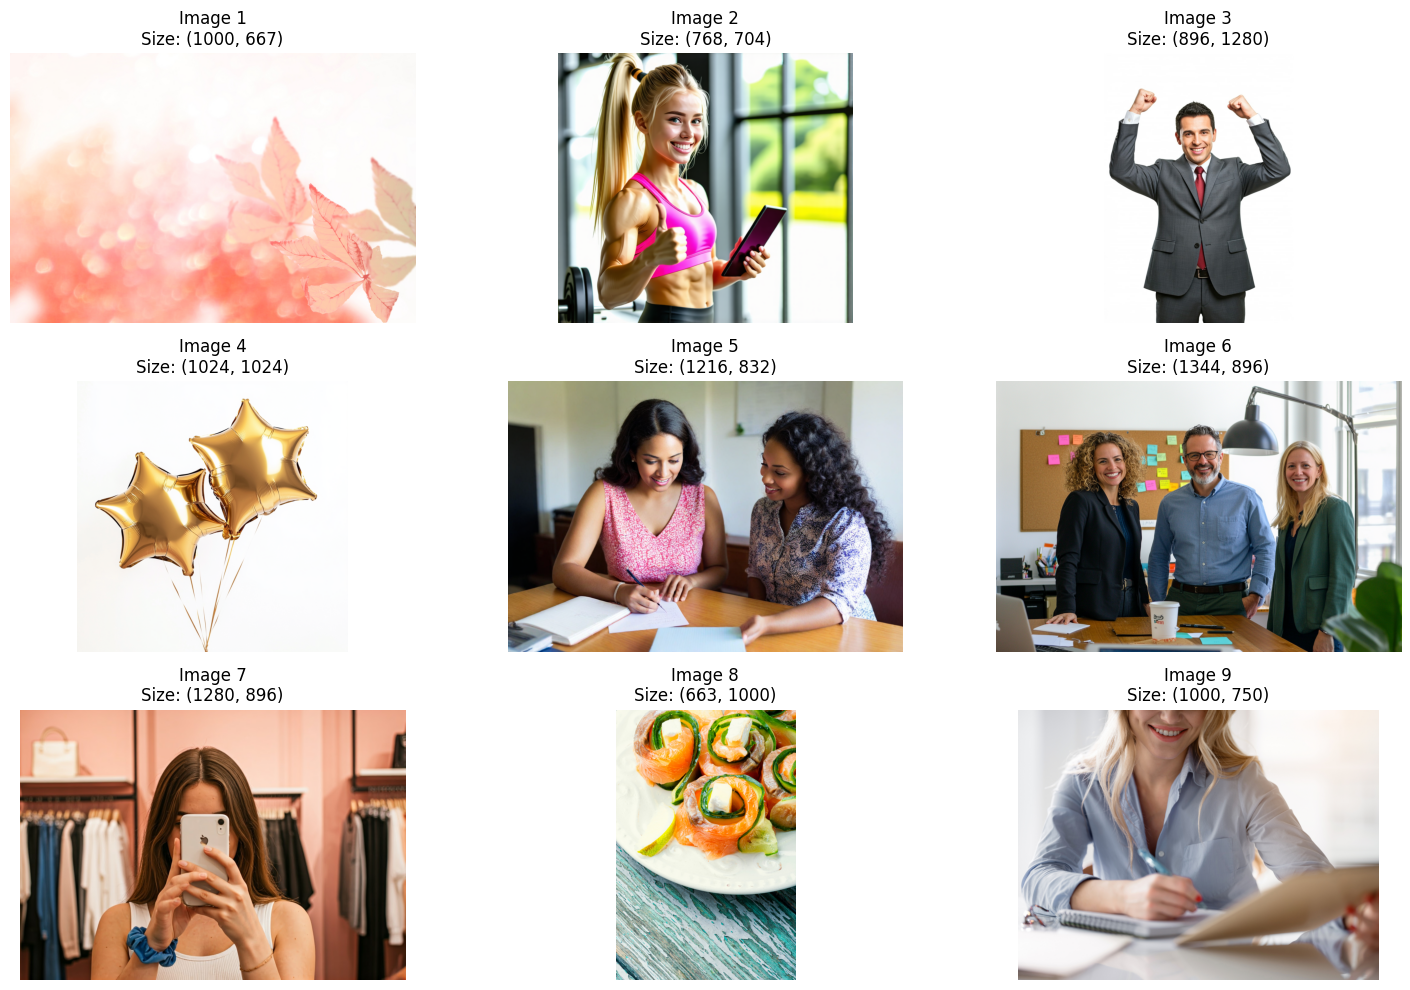

In [6]:
# Visualize a few random images from the dataset
plt.figure(figsize=(15, 10))
sample_size = min(9, len(image_paths))
for i in range(sample_size):
    plt.subplot(3, 3, i + 1)
    img = Image.open(image_paths[i])
    plt.imshow(img)
    plt.title(f'Image {i+1}\nSize: {img.size}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Initialize CLIP model
model_name = "openai/clip-vit-base-patch32"
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)
print(f"CLIP model initialized on {device}")

CLIP model initialized on cpu


In [15]:
# Process all images in batches
print("Generating embeddings...")
batch_size = 32
all_features = []

for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i + batch_size]
    images = [Image.open(path).convert('RGB') for path in batch_paths]

    inputs = processor(images=images, return_tensors="pt").to(device)

    with torch.no_grad():
        features = model.get_image_features(**inputs)

    all_features.append(features.cpu())
    print(f"Processed {i + len(batch_paths)}/{len(image_paths)} images")

image_embeddings = torch.cat(all_features)
print(f"Generated embeddings shape: {image_embeddings.shape}")

Generating embeddings...
Processed 32/500 images
Processed 64/500 images
Processed 96/500 images
Processed 128/500 images
Processed 160/500 images
Processed 192/500 images
Processed 224/500 images
Processed 256/500 images
Processed 288/500 images
Processed 320/500 images
Processed 352/500 images
Processed 384/500 images
Processed 416/500 images
Processed 448/500 images
Processed 480/500 images
Processed 500/500 images
Generated embeddings shape: torch.Size([500, 512])


Generating t-SNE visualization of the embeddings...


c:\Users\shaund\projects\multimodalimageretrievalsystem\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\shaund\projects\multimodalimageretrievalsystem\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


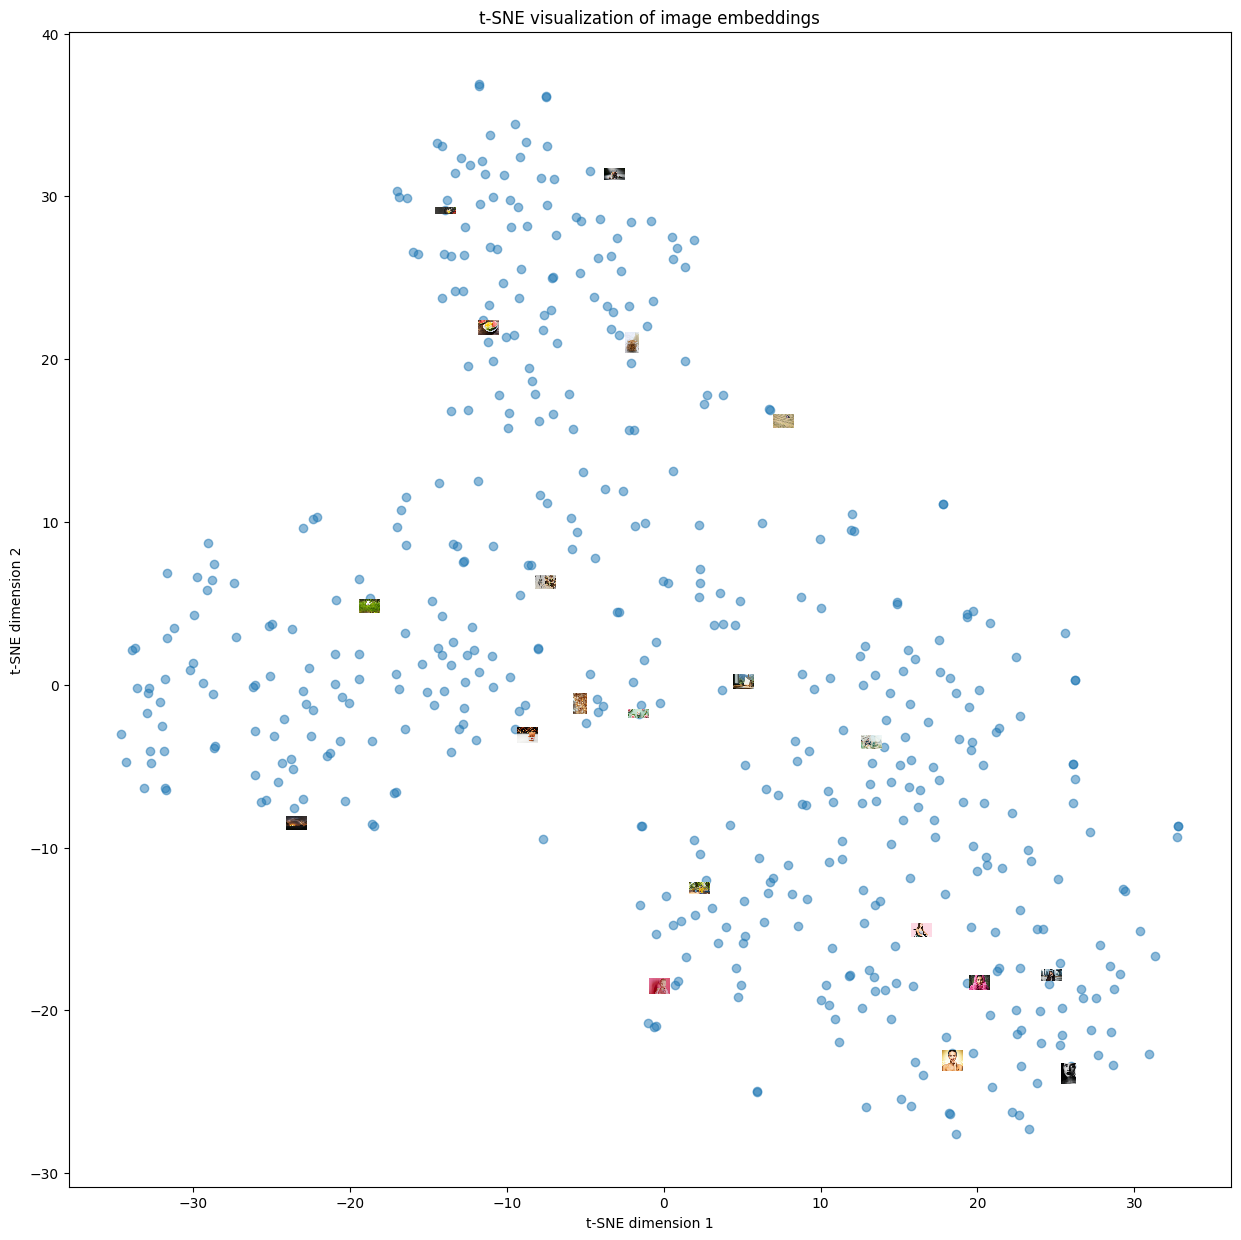

In [8]:
print("Generating t-SNE visualization of the embeddings...")

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(image_embeddings.numpy())

plt.figure(figsize=(15, 15))

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

# Add small image thumbnails for a subset of points
thumbnail_size = 0.15 
num_thumbnails = min(20, len(image_paths)) 
indices = np.random.choice(len(image_paths), num_thumbnails, replace=False)

for idx in indices:
    img = Image.open(image_paths[idx])
    img.thumbnail((100, 100))
    
    # Create OffsetImage
    imagebox = OffsetImage(img, zoom=thumbnail_size)
    ab = AnnotationBbox(imagebox, (embeddings_2d[idx, 0], embeddings_2d[idx, 1]), frameon=False)
    plt.gca().add_artist(ab)

plt.title('t-SNE visualization of image embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()



In [13]:
# Single query example
query = "a beautiful sunset over the ocean"
print(f"\nQuery: {query}")


Query: a beautiful sunset over the ocean


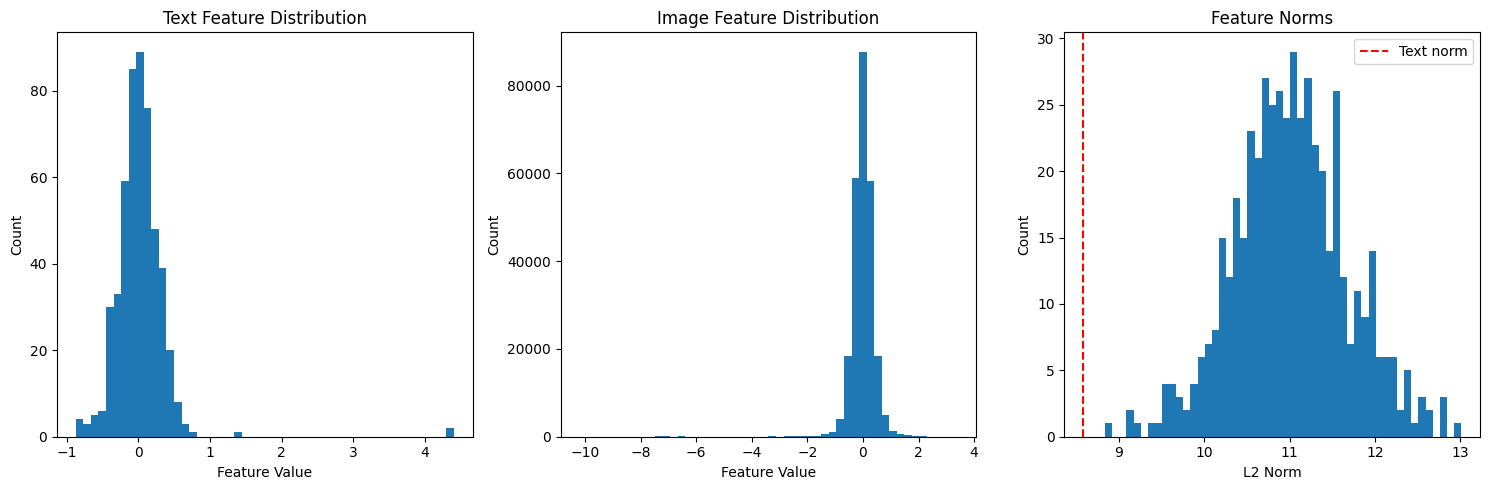


Features before normalization:
Text features shape: (1, 512)
Image features shape: (500, 512)
Text features norm: 8.581202
Image features norm (first 5): [np.float32(12.406704), np.float32(11.547846), np.float32(12.513417), np.float32(11.751806), np.float32(11.983307)]


In [ ]:
# Calculate similarity with clip
inputs = processor(text=query, return_tensors="pt", padding=True)
text_features = model.get_text_features(**inputs)
text_features = text_features.detach().cpu().numpy()

image_features = image_embeddings.detach().numpy()

# Check the images before normalization
print("\nFeatures before normalization:")
print("Text features shape:", text_features.shape)
print("Image features shape:", image_features.shape)
print("Text features norm:", np.linalg.norm(text_features[0]))
print("Image features norm (first 5):", 
      [np.linalg.norm(feat) for feat in image_features[:5]])

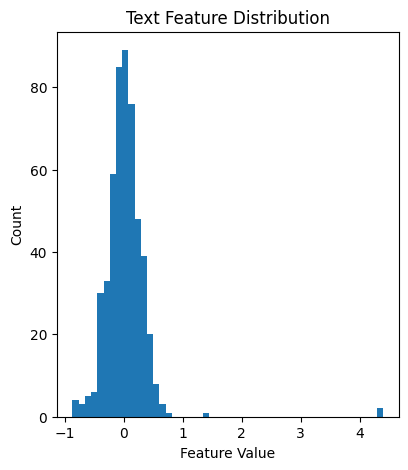

In [23]:
# let's try to vvisualize the distribution of the text feature and the distribution of the image feature
plt.figure(figsize=(15, 5))

# Plot text feature distribution
plt.subplot(131)
plt.hist(text_features.flatten(), bins=50)
plt.title('Text Feature Distribution')
plt.xlabel('Feature Value')
plt.ylabel('Count')
plt.show()

Text(0, 0.5, 'Count')

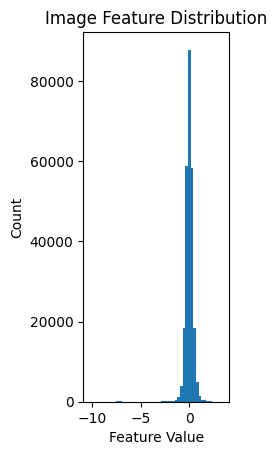

In [24]:
# Plot image feature distribution
plt.subplot(132)
plt.hist(image_features.flatten(), bins=50)
plt.title('Image Feature Distribution')
plt.xlabel('Feature Value')
plt.ylabel('Count')

In [ ]:
# Plot feature norms
plt.subplot(133)
img_norms = [np.linalg.norm(feat) for feat in image_features]
plt.hist(img_norms, bins=50)
plt.axvline(np.linalg.norm(text_features[0]),
            color='r', linestyle='--', label='Text norm')
plt.title('Feature Norms')
plt.xlabel('L2 Norm')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Normalize features for cosine similarity
text_features = text_features / \
    np.linalg.norm(text_features, axis=1, keepdims=True)
image_features = image_features / \
    np.linalg.norm(image_features, axis=1, keepdims=True)

# Print shapes and norms to verify normalization
print("Text features shape:", text_features.shape)
print("Image features shape:", image_features.shape)
print("\nVerifying normalization:")
print("Text features norm:", np.linalg.norm(text_features[0]))
print("Image features norm (first 5):", 
      [np.linalg.norm(feat) for feat in image_features[:5]])


Text features shape: (1, 512)
Image features shape: (500, 512)

Verifying normalization:
Text features norm: 1.0
Image features norm (first 5): [np.float32(1.0), np.float32(1.0), np.float32(1.0000001), np.float32(1.0), np.float32(1.0)]


In [20]:
# Calculate cosine similarities
similarities = (text_features @ image_features.T)[0]
top_indices = np.argsort(similarities)[-5:][::-1] 

# top 5 similarity scores
print("\nTop 5 similarity scores:")
for i, idx in enumerate(top_indices, 1):
    print(f"#{i}: {similarities[idx]:.3f}")


Top 5 similarity scores:
#1: 0.245
#2: 0.244
#3: 0.244
#4: 0.237
#5: 0.230


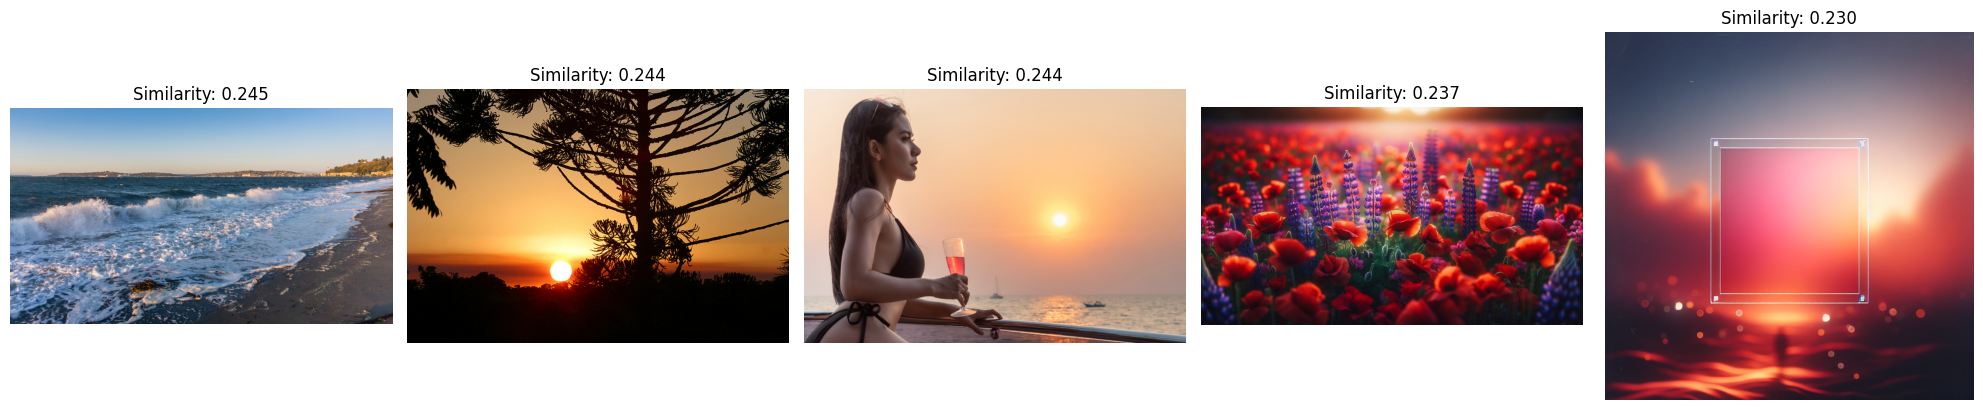

In [17]:
# Plot results
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, idx in zip(axes, top_indices):
    img = Image.open(image_paths[idx])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Similarity: {similarities[idx]:.3f}')
plt.tight_layout()
plt.show()

In [18]:
# Print metrics
print(f"Mean similarity: {np.mean(similarities[top_indices]):.3f}")
print(f"Max similarity: {np.max(similarities[top_indices]):.3f}")
print(f"Min similarity: {np.min(similarities[top_indices]):.3f}")

Mean similarity: 0.240
Max similarity: 0.245
Min similarity: 0.230


In [13]:
queries = [
    "man on the beach",
    "a cute puppy playing in the grass", 
    "a modern city skyline at night",
]

for query in queries:
    print(f"\nQuery: {query}")
    
    inputs = processor(text=query, return_tensors="pt", padding=True)
    text_features = model.get_text_features(**inputs)
    text_features = text_features.detach().cpu().numpy()
    
    image_features = image_embeddings.detach().numpy()
    
    text_features = text_features / np.linalg.norm(text_features, axis=1, keepdims=True)
    image_features = image_features / np.linalg.norm(image_features, axis=1, keepdims=True)
    
    # find top 5 matching neighbors using similarities 
    similarities = (text_features @ image_features.T)[0]
    top_indices = np.argsort(similarities)[-5:][::-1]  

    # Plot results
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for ax, idx in zip(axes, top_indices):
        img = Image.open(image_paths[idx])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Similarity: {similarities[idx]:.3f}')
    plt.tight_layout()
    plt.show()

    print(f"Mean similarity: {np.mean(similarities[top_indices]):.3f}")
    print(f"Max similarity: {np.max(similarities[top_indices]):.3f}")
    print(f"Min similarity: {np.min(similarities[top_indices]):.3f}")


Query: man on the beach


NameError: name 'processor' is not defined

In [23]:
import requests
import json
from pathlib import Path

url = "http://localhost:8000/api/v1/search/"

query = "a beautiful sunset over the ocean"

response = requests.post(
    url,
    json={"query": query},
    headers={"Content-Type": "application/json"}
)

if response.status_code == 200:
    results = response.json()["results"]
    print(f"\nFound {len(results)} results for query: '{query}'\n")
    
    for i, result in enumerate(results, 1):
        print(f"Result {i}:")
        print(f"Path: {result['path']}")
        print(f"Similarity: {result['similarity']:.3f}")
        print()
else:
    print(f"Error: {response.status_code}")
    print(response.text)


Found 5 results for query: 'a beautiful sunset over the ocean'

Result 1:
Path: C:\Users\shaund\.cache\kagglehub\datasets\alessandrasala79\ai-vs-human-generated-dataset\versions\4\test_data_v2\0b1dd9e9810e407d816042df25e8ea8a.jpg
Similarity: 0.245

Result 2:
Path: C:\Users\shaund\.cache\kagglehub\datasets\alessandrasala79\ai-vs-human-generated-dataset\versions\4\test_data_v2\0c2a117caa6648029896ebfdf5768cfd.jpg
Similarity: 0.244

Result 3:
Path: C:\Users\shaund\.cache\kagglehub\datasets\alessandrasala79\ai-vs-human-generated-dataset\versions\4\test_data_v2\0b3c2130251b434aa25fbc6712f97401.jpg
Similarity: 0.244

Result 4:
Path: C:\Users\shaund\.cache\kagglehub\datasets\alessandrasala79\ai-vs-human-generated-dataset\versions\4\test_data_v2\0c1fb4a1a67e478184fe842849a64ffd.jpg
Similarity: 0.230

Result 5:
Path: C:\Users\shaund\.cache\kagglehub\datasets\alessandrasala79\ai-vs-human-generated-dataset\versions\4\test_data_v2\09fe2110cc674b3aa92d02c1862da6c4.jpg
Similarity: 0.228

